# Time Series Fundamentals

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt

In [2]:
#get data
data_path = 'BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'
bitcoin_df = pd.read_csv(data_path, parse_dates=['Date'], index_col=['Date'])
print(f'length : {len(bitcoin_df)} row')
bitcoin_df.head(10)

length : 2787 row


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266


In [3]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
#only want closing price
bitcoin_prices = pd.DataFrame({'Price':bitcoin_df['Closing Price (USD)']})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


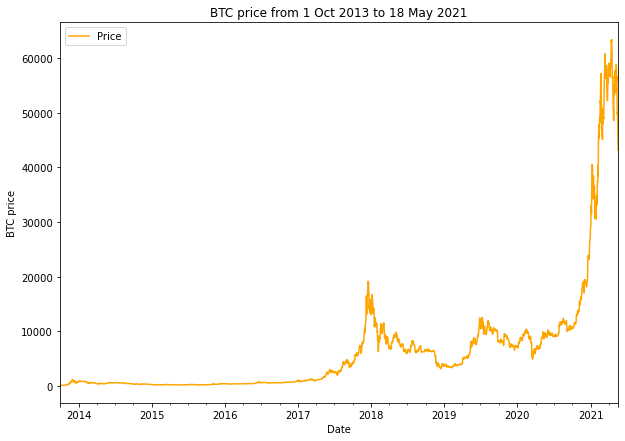

In [5]:
bitcoin_prices.plot(figsize=(10,7), color='orange')
plt.ylabel('BTC price')
plt.title('BTC price from 1 Oct 2013 to 18 May 2021');

## Create train and test set
time seris : use past feature to predict the future

In [6]:
times = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

train_size = int(len(times) *.8)
X_train, y_train = times[:train_size], prices[:train_size]
X_test, y_test = times[train_size:], prices[train_size:]

X_train.shape, X_test.shape , len(times)

((2229,), (558,), 2787)

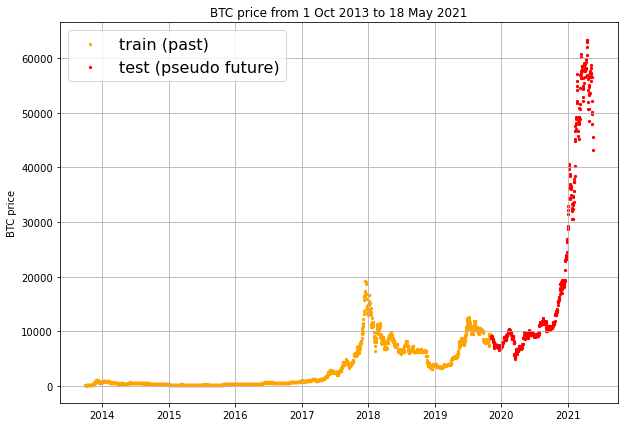

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, c='orange', label='train (past)')
plt.scatter(X_test, y_test, s=5, c='red', label='test (pseudo future)')
plt.legend(fontsize=16)
plt.grid(True)
plt.ylabel('BTC price')
plt.title('BTC price from 1 Oct 2013 to 18 May 2021');

## Model 0 | Naive forecast
in formular : $$\hat{y}_{t} = y_{t-1}$$

the prediction at timestep t(y-hat) is equal to the value at timestep t-1 (previous timestep) - for horizon of 1

**For example**, suppose we have the following sales of a given product during the first three months of the year:

<img src="https://www.statology.org/wp-content/uploads/2020/12/naive_forecast2-300x181.png"/>

The forecast for sales in April would simply be equal to the actual sales from the previous month of March:

*Although this method is simple, it tends to work surprisingly well in practice.*

In [8]:
#create Naive forecast
naive_forecast = y_test[:-1]
print('forecast :',naive_forecast[-4:])
print('actual :',y_test[-4:])

forecast : [49764.1320816  50032.69313676 47885.62525472 45604.61575361]
actual : [50032.69313676 47885.62525472 45604.61575361 43144.47129086]


### MASE (Mean Absolute Scaled Error) 
for time series forcasting metrics

metric that allows you to compare two models. Using the MAE for each model, If the MASE value is less than 1, then the new model performs better. If the MASE value is greater than 1, then the original model performed better than the new model.

<img src="https://miro.medium.com/max/964/1*hImatS5n4JjrAP09f0qduQ.png"/>

In [479]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    """
    mae = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive # original model is naive forcast

In [10]:
mean_absolute_scaled_error(y_test[1:], naive_forecast)

0.9995699939182626

In [480]:
#create evaluate metrics
def evaluate_score(y_true, y_pred) :
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred )/y_true)) # Mean absolute percentage error
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        'mape':mape,
        'mase':mase
    }

In [12]:
naive_score = evaluate_score(y_test[1:], naive_forecast)
naive_score

{'mae': 567.9802273457542,
 'mse': 1147547.125023896,
 'rmse': 1071.2362601330744,
 'mape': 0.02516524929982267,
 'mase': 0.9995699939182626}

### windowing our dataset
to turn data into a supervised learning problem

windowing for 1 week:<br>
[0, 1, 2, 3, 4, 5, 6] -> [7]<br>
[1, 2, 3, 4, 5, 6, 7] -> [8]

In [13]:
print(prices[:7] ,'->',prices[7])

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> 123.033


In [14]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [15]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [16]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange( len(x)-(window_size+horizon-1) ), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [17]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [18]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_size=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  train_size = int(len(windows) * (1-test_size)) # this will default to 80% train/20% test
  train_windows = windows[:train_size]
  train_labels = labels[:train_size]
  test_windows = windows[train_size:]
  test_labels = labels[train_size:]
  return train_windows, test_windows, train_labels, test_labels

In [19]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Create ModelCheckpoint

In [20]:
def crete_model_checkpoint(model_name, save_path='model_experiment'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), save_best_only=True, monitor='val_loss')

## Model 1 : Dense Model (window = 7, horizon = 1)

In [21]:
tf.random.set_seed(42)
inputs = keras.Input(shape=(7,), name='input_layers')
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1)(x)
model_1 = keras.Model(inputs, outputs, name='dense_model')

model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_1 = model_1.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_1.name)])

18/18 [==============================] - 0s 4ms/step - loss: 105.7481 - mae: 105.7481 - mse: 68589.9609 - val_loss: 593.0125 - val_mae: 593.0125 - val_mse: 1230072.6250
Epoch 88/100
18/18 [==============================] - 1s 55ms/step - loss: 107.2604 - mae: 107.2604 - mse: 70897.3438 - val_loss: 571.7660 - val_mae: 571.7660 - val_mse: 1182083.1250
Epoch 89/100
18/18 [==============================] - 1s 47ms/step - loss: 106.7823 - mae: 106.7823 - mse: 69118.5469 - val_loss: 568.6370 - val_mae: 568.6370 - val_mse: 1174330.0000
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8682 - mae: 105.8682 - mse: 67370.7109 - val_loss: 602.9686 - val_mae: 602.9686 - val_mse: 1230766.5000
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6365 - mae: 110.6365 - mse: 72148.0547 - val_loss: 605.6950 - val_mae: 605.6950 - val_mse: 1257884.7500
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4669 - mae: 109.4669 - 

In [22]:
model_1.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 662.5316 - mae: 662.5316 - mse: 1358190.3750


[662.5316162109375, 662.5316162109375, 1358190.375]

In [24]:
#load the save best performing model
model_1 = keras.models.load_model('model_experiment/dense_model')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 658us/step - loss: 568.5499 - mae: 568.5499 - mse: 1172587.7500


[568.5499267578125, 568.5499267578125, 1172587.75]

In [25]:
predictions = model_1.predict(test_windows).reshape(-1,)
predictions[:10]

array([8874.493, 8789.944, 9040.987, 8804.829, 8741.212, 8749.836,
       8705.866, 8513.171, 8478.417, 8536.302], dtype=float32)

In [26]:
model_1_score = evaluate_score(test_labels.reshape(-1,), predictions)
model_1_score

{'mae': 568.5498587262708,
 'mse': 1172587.9917035494,
 'rmse': 1082.8610214166679,
 'mape': 0.025492293493015787,
 'mase': 0.9987845236174441}

In [119]:
def plot_preds(y_true, y_pred, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.grid(True)
    plt.scatter(np.arange(len(y_true)), y_true, s=5, color='blue',label='True')
    plt.plot(np.arange(len(y_true)), y_pred, color='orange',label='Prediction')
    plt.axis([400, 500, 30000, 50000]);
    plt.legend()

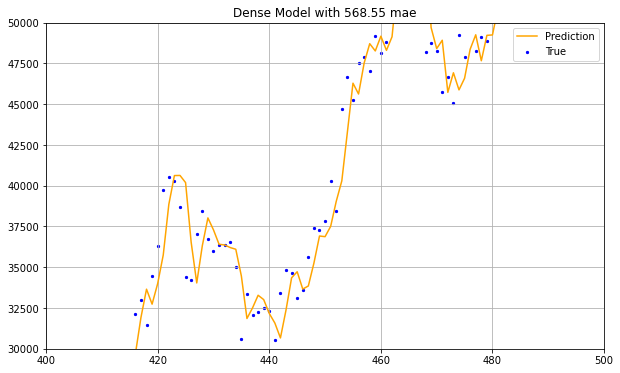

In [120]:
plot_preds(test_labels, predictions, 'Dense Model with 568.55 mae')

## Model 2 : window = 30, horizon = 1

In [103]:
full_windows, full_labels = make_windows(prices, 30, 1)
train_windows, test_windows, train_labels, test_labels =  make_train_test_splits(full_windows, full_labels) 
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [107]:
inputs = keras.Input(shape=(30,), name='input_layers')
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1)(x)
model_2 = keras.Model(inputs, outputs, name='model_2_30_windows')

model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_2 = model_2.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_2.name)])
model_2.summary()

18/18 [==============================] - 0s 7ms/step - loss: 136.7051 - mae: 136.7051 - mse: 91279.4375 - val_loss: 976.8763 - val_mae: 976.8763 - val_mse: 2397687.7500
Epoch 90/100
18/18 [==============================] - 1s 60ms/step - loss: 121.3645 - mae: 121.3645 - mse: 77886.6484 - val_loss: 609.0266 - val_mae: 609.0266 - val_mse: 1240527.5000
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 115.8130 - mae: 115.8130 - mse: 73674.9062 - val_loss: 733.7057 - val_mae: 733.7057 - val_mse: 1596269.8750
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 113.3364 - mae: 113.3364 - mse: 71596.3828 - val_loss: 703.3085 - val_mae: 703.3085 - val_mse: 1494611.6250
Epoch 93/100
18/18 [==============================] - 0s 3ms/step - loss: 122.4690 - mae: 122.4690 - mse: 76591.1875 - val_loss: 791.5176 - val_mae: 791.5176 - val_mse: 1777523.5000
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 121.7199 - mae: 121.7199 - m

In [110]:
print(model_2.evaluate(test_windows, test_labels))
model_2 = keras.models.load_model('model_experiment\model_2_30_windows')
print(model_2.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 2ms/step - loss: 628.9485 - mae: 628.9485 - mse: 1308321.3750
[628.9485473632812, 628.9485473632812, 1308321.375]
18/18 [==============================] - 0s 1ms/step - loss: 609.0266 - mae: 609.0266 - mse: 1240527.5000
[609.0265502929688, 609.0265502929688, 1240527.5]


In [111]:
predictions = model_2.predict(test_windows)

In [113]:
model_2_score = evaluate_score(test_labels, predictions)
model_2_score

{'mae': 609.026511713428,
 'mse': 1240527.5607729736,
 'rmse': 1113.7897291558104,
 'mape': 0.027580984405266695,
 'mase': 1.0645842295459536}

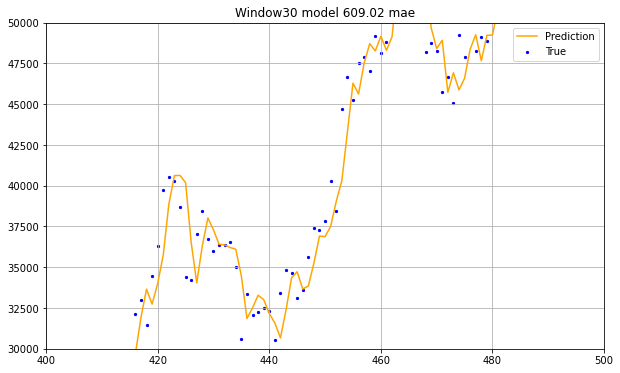

In [122]:
plot_preds(test_labels, predictions, 'Window30 model 609.02 mae')

## Model 3 : Dense (window = 30, horizon = 7)

In [136]:
full_windows, full_labels = make_windows(prices, 30, 7)
train_windows, test_windows, train_labels, test_labels =  make_train_test_splits(full_windows, full_labels) 
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [144]:
inputs = keras.Input(shape=(30,), name='input_layers')
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(7)(x)
model_3 = keras.Model(inputs, outputs, name='model_3_30_windows_7_horizon')

model_3.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_3 = model_3.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_3.name)])
model_3.summary()

18/18 [==============================] - 1s 41ms/step - loss: 234.4290 - mae: 234.4290 - mse: 284633.3125 - val_loss: 1293.9352 - val_mae: 1293.9352 - val_mse: 5741958.5000
Epoch 72/100
18/18 [==============================] - 1s 33ms/step - loss: 230.8540 - mae: 230.8540 - mse: 274532.5000 - val_loss: 1280.1530 - val_mae: 1280.1530 - val_mse: 5655746.0000
Epoch 73/100
18/18 [==============================] - 0s 3ms/step - loss: 227.3715 - mae: 227.3715 - mse: 271087.8125 - val_loss: 1305.5703 - val_mae: 1305.5703 - val_mse: 5825552.0000
Epoch 74/100
18/18 [==============================] - 0s 3ms/step - loss: 230.9245 - mae: 230.9245 - mse: 278803.7500 - val_loss: 1341.7219 - val_mae: 1341.7219 - val_mse: 5923718.5000
Epoch 75/100
18/18 [==============================] - 0s 3ms/step - loss: 230.8542 - mae: 230.8542 - mse: 273060.1875 - val_loss: 1501.7456 - val_mae: 1501.7456 - val_mse: 6683133.0000
Epoch 76/100
18/18 [==============================] - 0s 3ms/step - loss: 230.9980 - m

In [149]:
print(model_3.evaluate(test_windows, test_labels))
model_3 = keras.models.load_model('model_experiment\model_3_30_windows_7_horizon')
print(model_3.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 1ms/step - loss: 1270.1888 - mae: 1270.1888 - mse: 5764380.0000
[1270.1888427734375, 1270.1888427734375, 5764380.0]
18/18 [==============================] - 0s 814us/step - loss: 1270.1888 - mae: 1270.1888 - mse: 5764380.0000
[1270.1888427734375, 1270.1888427734375, 5764380.0]


In [153]:
predictions = model_3.predict(test_windows)

In [154]:
model_3_score = evaluate_score(test_labels, predictions)
model_3_score

{'mae': 1270.18884742303,
 'mse': 5764379.044027716,
 'rmse': 2400.91212751065,
 'mape': 0.05748978178182786,
 'mase': 2.26022985826414}

## Model 4 : Conv1D (window = 7, horizon = 1)

In [242]:
full_windows, full_labels = make_windows(prices, 7, 1)
train_windows, test_windows, train_labels, test_labels =  make_train_test_splits(full_windows, full_labels) 
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [ ]:
inputs = keras.Input(shape=(7,), name='input_layers')
x = keras.layers.Lambda(lambda z : tf.expand_dims(z, axis=1))(inputs) # expand to 2D array 
x = keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal')(x)
x = keras.layers.Dense(32)(x)
outputs = keras.layers.Dense(1)(x)
model_4 = keras.Model(inputs, outputs, name='model_4_conv1D')

model_4.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_4 = model_4.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=0, callbacks=[crete_model_checkpoint(model_4.name)])

In [244]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 7)]               0         
                                                                 
 lambda_34 (Lambda)          (None, 1, 7)              0         
                                                                 
 conv1d_33 (Conv1D)          (None, 1, 128)            4608      
                                                                 
 dense_31 (Dense)            (None, 1, 32)             4128      
                                                                 
 dense_32 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [249]:
print(model_4.evaluate(test_windows, test_labels))
model_4 = keras.models.load_model('model_experiment\model_4_conv1D')
print(model_4.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 1ms/step - loss: 582.3776 - mae: 582.3776 - mse: 1189357.8750
[582.3775634765625, 582.3775634765625, 1189357.875]
18/18 [==============================] - 0s 1ms/step - loss: 569.6910 - mae: 569.6910 - mse: 1173666.0000
[569.6910400390625, 569.6910400390625, 1173666.0]


In [273]:
y_preds = model_4.predict(test_windows).reshape(-1,1) #shape must be the same

In [274]:
model_4_score = evaluate_score(test_labels, y_preds) 
model_4_score

{'mae': 569.6910569607248,
 'mse': 1173666.0247214397,
 'rmse': 1083.3586777800967,
 'mape': 0.025421689903713362,
 'mase': 1.0007892926231137}

## Model 5 : RNN (LSTM)

In [ ]:
tf.random.set_seed(42)

inputs = keras.Input(shape=(7,), name='input_layer')
x = keras.layers.Lambda(lambda z : tf.expand_dims(z, axis=1))(inputs)
x = keras.layers.LSTM(128, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(1,)(x)
model_5 = keras.Model(inputs, outputs, name='model_5_LSTM')

model_5.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_5 = model_5.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_5.name)])

In [279]:
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7)]               0         
                                                                 
 lambda_37 (Lambda)          (None, 1, 7)              0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               69632     
                                                                 
 dense_37 (Dense)            (None, 32)                4128      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 73,793
Trainable params: 73,793
Non-trainable params: 0
_________________________________________________________________


In [281]:
print(model_5.evaluate(test_windows, test_labels))
model_5 = keras.models.load_model('model_experiment\model_5_LSTM')
print(model_5.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 2ms/step - loss: 613.2130 - mae: 613.2130 - mse: 1257102.8750
[613.2130126953125, 613.2130126953125, 1257102.875]
18/18 [==============================] - 0s 2ms/step - loss: 577.3130 - mae: 577.3130 - mse: 1197437.6250
[577.31298828125, 577.31298828125, 1197437.625]


In [282]:
y_preds = model_5.predict(test_windows).reshape(-1,1) #shape must be the same
model_5_score = evaluate_score(test_labels, y_preds) 
model_5_score

{'mae': 577.3130479666248,
 'mse': 1197437.8175510122,
 'rmse': 1094.2750191569814,
 'mape': 0.0259421916372879,
 'mase': 1.0141790183243902}

## Make a Multivariate time series dataset
what is influence BTC price ? (BTC halving event ?)

<img src="https://www.investopedia.com/thmb/URup7guRB6Eibv5qOXs7pTv0gDQ=/660x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/BlockReward-5c0ad88946e0fb0001af7198.png" width=500px/>

In [428]:
block_reward_1 = 50 # 9 jan 09 # not in our dataset
block_reward_2 = 25 # 28 nov 12
block_reward_3 = 25/2 # 9 july 16
block_reward_4 = 25/4 # 11 may 20

#block reward dates
block_reward_2date = np.datetime64('2012-11-28')
block_reward_3date = np.datetime64('2016-07-09')
block_reward_4date = np.datetime64('2020-05-11')

In [429]:
bitcoin_prices.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25.0
2013-10-02,125.45500,25.0
2013-10-03,108.58483,25.0
2013-10-04,118.67466,25.0
2013-10-05,121.33866,25.0


In [430]:
print(np.argmax(bitcoin_prices.index == block_reward_3date))
print(np.argmax(bitcoin_prices.index == block_reward_4date))

1012
2414


In [431]:
bitcoin_prices['block_reward'] = 0 # add for index easier
bitcoin_prices['block_reward'].iloc[:1012] = block_reward_2
bitcoin_prices['block_reward'].iloc[1012:2414] = block_reward_3
bitcoin_prices['block_reward'].iloc[2414:] = block_reward_4

c:\Users\alant\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [432]:
bitcoin_prices[::300]

,Price,block_reward
Date,,
2013-10-01,123.654990,25.00
2014-07-28,580.110000,25.00
2015-05-24,239.798500,25.00
2016-03-19,407.473000,25.00
2017-01-13,784.893750,12.50
2017-11-09,7342.823750,12.50
2018-09-05,7361.271864,12.50
2019-07-02,10454.683818,12.50
2020-04-27,7624.853786,12.50


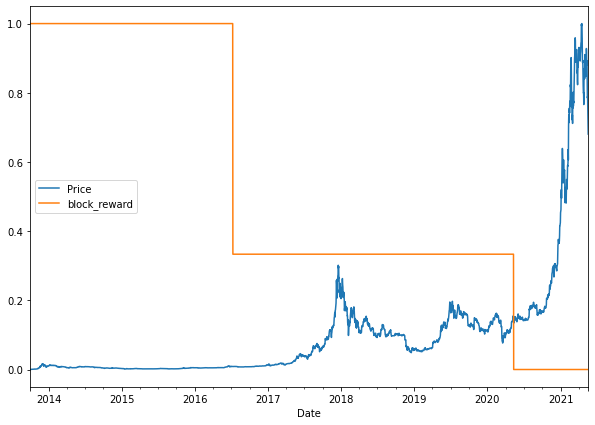

In [433]:
from sklearn.preprocessing import minmax_scale

bitcoin_scale = pd.DataFrame(minmax_scale(bitcoin_prices[['Price', 'block_reward']]), columns=bitcoin_prices.columns, index=bitcoin_prices.index)
bitcoin_scale.plot(figsize=(10,7));

In [434]:
# make windowing with pandas
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_windowed = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_windowed[f'Price+{i+1}'] = bitcoin_windowed['Price'].shift(periods=i+1) # shife down for i+1 row

bitcoin_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [435]:
X = bitcoin_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_windowed.dropna()['Price'].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [436]:
train_size = int(len(bitcoin_windowed) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, y_train.shape

((2229, 8), (2229,))

## Model 6 : Dense (multivariate time series)

In [469]:
tf.random.set_seed(42)
inputs = keras.Input(shape=(8,))
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1)(x)
model_6 = keras.Model(inputs, outputs, name='multivariate_model6')
model_6.summary()

Model: "multivariate_model6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_81 (Dense)            (None, 128)               1152      
                                                                 
 dense_82 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_6.compile(loss='mae', optimizer='adam', metrics=['mae','mse'])
model_6.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=0,callbacks=[crete_model_checkpoint(model_name=model_6.name)])

In [471]:
model_6 = tf.keras.models.load_model('model_experiment\multivariate_model6')
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 967us/step - loss: 575.5084 - mae: 575.5084 - mse: 1183149.1250


[575.5084228515625, 575.5084228515625, 1183149.125]

In [485]:
y_preds = model_6.predict(X_test).reshape(-1,)
model_6_score = evaluate_score(y_true=y_test.to_numpy().reshape(-1,1), y_pred=y_preds.reshape(-1,1))
model_6_score

{'mae': 575.5085,
 'mse': 1183149.5,
 'rmse': 1087.7268,
 'mape': 0.02566463,
 'mase': 1.0044637}